# Optimisation non linéaire de type Mix de Produits.

## Introduction

Dans ce notebook, je vais faire une optimisation non linéaire de type mixe de produits.
C'est non linéaire, parce que , plus l'usine réalise de produits, moins le prix de vente est cher
 ce qui provoque une élevation au carré dans la fonction objectif.
J'ajoute des contraintes de stocks et de temps de travail Maximum.
Et si le nombre d'objets produits A, B ou C dépasse un certain nombre, alors un coût de maintenance k s'applique ( Coûts discontinus).
De plus on va modéliser le problème mathématique à l'aide de Latex avant tout.

** CREATION EN COURS **

Etude Estelle Derrien 2023

# Sommaire :

- Description du problème
- Modélisation mathématique avec Latex.
- Création du problème avec Gekko.
- Graphique du prix de vente en fonction de la quantité d'objets produits
- Création de boucles for  dans la fonction objectif et les contraintes , pour écrire plus vite l'optimisation.
- Graphique des coûts variables.
- Modélisation mathématique des variables binaires conditionnelles discontinues.
- Ajout des variables discontinues dans le programme GEKKO.
- Liens Internet nécessaires pour comprendre.


# Description du problème

J'ai une machine qui produit 3 pièces. La machine peut travailler 1000 heures au maximum. 

Le prix de vente des pièces A,B et C diminue avec la quantité produite.

Le prix de vente de la pièce A est 81-quantité de A/20 ( Le prix décroit si on produit beaucoup)

Le prix de vente de la pièce B est 90-quantité de B/10 

Le prix de vente de la pièce C est 85-quantité de C/10 

On a pour contrainte de stocks 3000 kgs de métal,
2000 heures de temps de travail et 2500 kgs de plastique.

si A, B ou C sont  < 500, alors on soustrait 10 euros de coût de maintenance dans la fonction objectif.

si A, B ou C sont > 500 alors on soustrait 20 euros de côut de maintenance dans é la fonction objectif.



Quel type et Combien de pièces produire afin de maximiser mon profit ?

# Modélisation mathématique
(Il y a un Bug de passage de lignes dans Github)

$$
max \sum_{1}^{i}  xi * (PrixVente(i) - \frac{xi}{Reduction}) \newline
\textit{Sous les contraintes} \newline
\sum_{1}^{i} xi * Metal(i) \leq 3000 \newline
\sum_{1}^{i} xi * Htravail(i) \leq 2000 \newline
\sum_{1}^{i} xi * Plastique(i) \leq 2500 \newline
$$
Et maintenant, les 3 variables conditionnelles :

A faire



On réécrit la modélisation comme ça, à cause du bug de passage des lignes dans github.

In [41]:


from IPython.display import display, Math, Latex
display(Math(r'max \sum_{1}^{i}  xi * (prixVente(i) - \frac{xi}{reduction}) '))
display(Math(r'Sous.les.contraintes'))
display(Math(r'\sum_{1}^{i} xi * metal(i) \leq 3000 '))
display(Math(r'\sum_{1}^{i} xi * h_travail(i) \leq 2000 '))
display(Math(r'\sum_{1}^{i} xi * plastique(i) \leq 2500 '))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Création du problème avec Gekko.

Dans un premier temps, on va déjà faire tourner le programme sans les variables binaires, mais avec seulements les contraintes de type stock et temps machine .

In [42]:
# On importe Gekko
from gekko import GEKKO

m = GEKKO(remote=False) # Initialize gekko

#The example problem that you referenced uses the default IPOPT solver. 
# To get a binary or integer solution, switch to the APOPT solver.
# The default solver is IPOPT and it doesn't give an integer solution. Try the APOPT solver instead.
# https://apmonitor.com/wiki/index.php/Main/OptionApmSolver
m.options.SOLVER = 1

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 1000
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# Les caractéristiques de nos produits A, B et C au format dictionnaire, 
# pour pouvoir itérer dessus ensuite dans les contraintes.
prix_vente = {'A':81,'B':90,'C':85}
metal = {'A':3,'B':4,'C':5}
travail = {'A':1,'B':2,'C':2}
plastique = {'A':3,'B':5,'C':4}

# On crée les variables de décision , ce sera notre nombre de pièces à réaliser, vu qu'on ne 
# peut pas avoir 1/2 objet, on dit que ce sont des variables entières.

A = m.Var(value=1,lb=0,ub=10000,integer=True)
B = m.Var(value=1,lb=0,ub=10000,integer=True)
C = m.Var(value=1,lb=0,ub=10000,integer=True)

# Voici notre fonction objectif , qui tient compte du fait que plus on produits de pièces, Moins ça coute cher !!
# On voit qu'elle est non linéaire parce que A , B et C sont élevés au carré !!
m.Maximize( A * (81 - ( A / 20  )) + B * (90 - (B / 10)) + C * (85 - (C / 10)))

# contraintes
m.Equation( A + B + C <= disponibilite_machine) # La machine un peut travailler 1000 heures maximum
m.Equation(3 * A + 4 * B + 5 * C <= stock_metal)
m.Equation(1 * A + 2 * B + 2 * C <= stock_heures_travail)
m.Equation(3 * A + 5 * B + 4 * C <= stock_plastique)

# Cette contrainte écrite à la manière de Python Pulp ne fonctionne pas.
# m.Equation(sum(metal[i] * pieces[i] for i in pieces) <= stock_metal)

# On imprime le résultat 
m.options.IMODE = 3 # Steady state optimization

m.solve(disp=False) # Solve

print('Solution')

print('A: ' + str(A.value))
print('B: ' + str(B.value))
print('C: ' + str(C.value))

print('Objectif: ' + str(-m.options.objfcnval))

Solution
A: [415.0]
B: [121.0]
C: [162.0]
Objectif: 45575.25


# Graphique du prix de vente en fonction de la quantité d'objets produits

Le prix unitaire décroit quand la production est plus importante.

Text(0, 0.5, 'Prix unitaire')

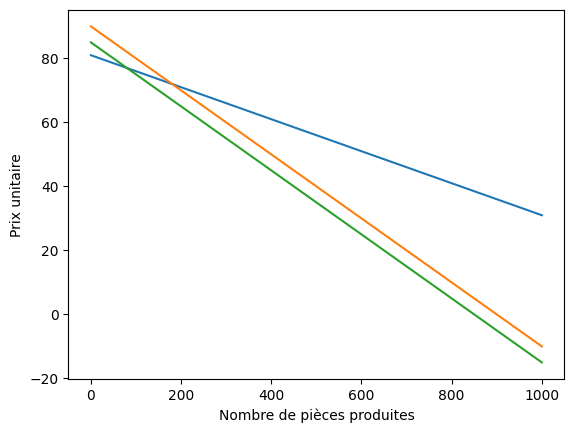

In [43]:


import matplotlib.pyplot as plt
import numpy as np

def f(A):
    return 81 - ( A / 20  ) 
def fb(B):
    return 90 - (B / 10)
def fc(C):
    return 85 - (C / 10)


x = np.linspace(0, 1000, 1000)
plt.plot(x, f(x))
plt.plot(x, fb(x))
plt.plot(x, fc(x))
plt.xlabel('Nombre de pièces produites')
plt.ylabel('Prix unitaire')


# Création de boucles for pour aller plus vite dans l'optimisation.

Pour itérer avec Gekko, c'est malheureusement différent du solveur Python Pulp : 

https://stackoverflow.com/questions/64542594/how-could-constraints-be-dynamically-constructed-in-gekko

https://www.solvermax.com/blog/production-mix-model-9-gekko

On essaye donc d'itérer dans la fonction objectif et les contraintes, avec la méthode de John Hedengren :


In [44]:
# On importe Gekko
from gekko import GEKKO

m = GEKKO(remote=False) # Initialize gekko

m.options.SOLVER = 1

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 500
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# Les caractéristiques de nos produits A, B et C au format dictionnaire, 
# pour pouvoir itérer dessus ensuite dans les contraintes.
prix_vente = {'A':81,'B':90,'C':85}
metal = {'A':3,'B':4,'C':5}
travail = {'A':1,'B':2,'C':2}
plastique = {'A':3,'B':5,'C':4}

# On crée les variables de décision avec la méthode de John Hedengren
va = m.Array(m.Var,(len(pieces)))  # array

# on crée un dictionnaire, astuce donnée par John Hedengren, pour pouvoir itérer après dans les contraintes
vd = {}                             # dictionary
for i,xi in enumerate(pieces):
    vd[xi] = va[i]

# Voici notre fonction objectif , qui tient compte du fait que plus on produits de pièces, Moins ça coute cher !!
# On voit qu'elle est non linéaire parce que A , B et C sont élevés au carré !!
# m.Maximize( A * (81 - ( A / 20  )) + B * (90 - (B / 10)) + C * (85 - (C / 10)))

# On se sert du tableau pour écrire la fonction objectif
m.Maximize( va[0] * (81 - ( va[0] / 20 )) + va[1] * (90 - ( va[1] / 10)) +  va[2]  * (85 - (va[2]  / 10) ))


# Contraintes, On les écrit désormais en itérant

# m.Equation(3 * A + 4 * B + 5 * C <= stock_metal) ( Ancienne équation ) = 
m.Equation(m.sum([metal[xi]*vd[xi] for xi in pieces])<=stock_metal)

# m.Equation(1 * A + 2 * B + 2 * C <= stock_heures_travail) ( Ancienne équation ) = 
m.Equation(m.sum([travail[xi]*vd[xi] for xi in pieces])<=stock_heures_travail)

# m.Equation(3 * A + 5 * B + 4 * C <= stock_plastique) ( Ancienne équation ) = 
m.Equation(m.sum([plastique[xi]*vd[xi] for xi in pieces])<=stock_plastique)


# On imprime le résultat 
m.options.IMODE = 3 # Steady state optimization

m.solve(disp=False) # Solve

print('Solution')

# On affiche le résultat
for xi in pieces:
    print(xi,vd[xi].value[0])


print('Objectif: ' + str(-m.options.objfcnval))

# On voit qu'on trouve la même solution que sans itérer, sauf que là on est en variables décisions continues .


Solution
A 415.42372881
B 121.18644068
C 161.94915254
Objectif: 45601.567797


# Ajout des variables binaires conditionnelles.

Création En cours !

Tout d'abord, on visualise nos contraintes de type <b>discontinues</b> avec Matplot lib :

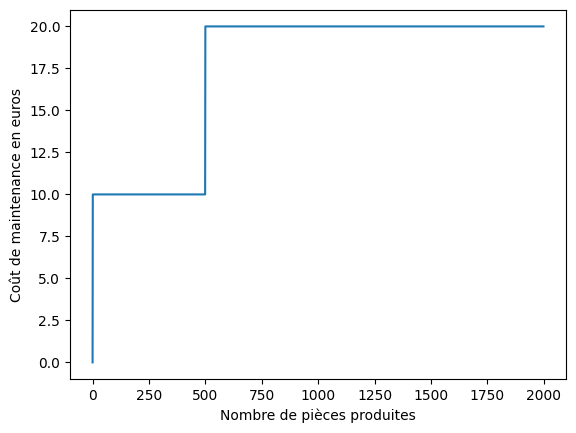

In [45]:
# On visualise nos contraintes de type discontinues avec les valeurs réelles de notre problème
import matplotlib.pyplot as plt
plt.plot([0,0,1,499,500,1999], [0,0,10, 10, 20,20,])
plt.xlabel('Nombre de pièces produites')
plt.ylabel('Coût de maintenance en euros')
plt.show()

# Liens : 
- https://stackoverflow.com/questions/74133047/binary-variable-in-gekko-optimization-problem

- https://math.stackexchange.com/questions/1851140/binary-integer-variables-in-linear-programming

- https://towardsdatascience.com/hands-on-integer-binary-linear-optimization-using-python-b6d8160cb1de

- https://stackoverflow.com/questions/56854536/from-pulp-to-gekko-syntax-mapping-for-constraints-objective-function

- https://stackoverflow.com/questions/64577733/how-to-make-constriants-in-gekko-by-for-loop

- https://stackoverflow.com/questions/64542594/how-could-constraints-be-dynamically-constructed-in-gekko